In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from matplotlib.ticker import PercentFormatter
import seaborn as sns

In [2]:
dataset = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', 
    sep=',', 
    header=None
)

In [3]:
dataset.head(5)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


The goal of this project is to build a classification algorithm that predicts whether a mushroom is edible or poisonous and therefore not edible. If edible = 0 and poisonous = 1, then because a false negative (predicted as 0 or edible but was supposed to be 1 or poisonous) is much more detrimental than a false positive (predicted as 1 or poisonous but instead was 0 or edible), we can first build a model and then work on changing a threshold that will maximize sensitivity, which is how well the model predicts true positives. The better it predicts the poisonous mushrooms to be poisonous, the better. 

# Section 1: Data Preparation

# Step 1: Data labeling 

Because the current data have neither have a column header nor the dictionary that suggest what each value in a cell mean, we do not have any information as to what this dataset is about. Therefore, the natural first step to take is to label the data appropriately. 

Labeling of the data can be found within the same folder the dataset was found in. The relevant information is found in https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names in the form of a write-up. Because it is in the form of a write up, I will first save the file as a txt file, and then data mine the relevant information by reading it into Python as a txt file via regular expressions.

In [4]:
# Importing the information document into Python to mine data from

with open(r"C:\Users\taked\Desktop\DataScience Projects\Non-Kaggle Datasets\UCI_Mushroom\agaricus-lepiota.names.txt",'r') as txt:
    file_content = [line.rstrip("\n").lstrip("\t") for line in txt] # Reads in txt, cleans each line, and stores each line in a list
    cleaned_file_content = [line for line in file_content if line != ''] # Filters out '' found in file_content, which originally signified 
                                                                         # empty lines
    

In [5]:
# What the cleaned version of the txt file looks like in a list. Relevant information will be mined from here
cleaned_file_content

['1. Title: Mushroom Database',
 '2. Sources: ',
 '    (a) Mushroom records drawn from The Audubon Society Field Guide to North',
 '        American Mushrooms (1981). G. H. Lincoff (Pres.), New York: Alfred',
 '        A. Knopf',
 '    (b) Donor: Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)',
 '    (c) Date: 27 April 1987',
 '3. Past Usage:',
 '    1. Schlimmer,J.S. (1987). Concept Acquisition Through Representational',
 '       Adjustment (Technical Report 87-19).  Doctoral disseration, Department',
 '       of Information and Computer Science, University of California, Irvine.',
 '       --- STAGGER: asymptoted to 95% classification accuracy after reviewing',
 '           1000 instances.',
 '    2. Iba,W., Wogulis,J., & Langley,P. (1988).  Trading off Simplicity',
 '       and Coverage in Incremental Concept Learning. In Proceedings of ',
 '       the 5th International Conference on Machine Learning, 73-79.',
 '       Ann Arbor, Michigan: Morgan Kaufmann.  ',
 '       -- approx

From reading this, many useful information about the dataset is learned. For example, we learned the distribution of our dependent variable for this study, edible vs poisonous. The information of our interest in the context of labeling our dataset is found in section 7, titled Attribute Information. Information will be scraped from this section. 

# Step 1 Part 1: Data mining

In [6]:
# Scraping the section of the text file that contains the relevant information. The label information is in the Attribute Information section.

for line in cleaned_file_content:
    if "Attribute Information:" in line:
        start_index = cleaned_file_content.index(line)
    if "Missing Attribute Values:" in line:
        end_index = cleaned_file_content.index(line)
        
label_section = cleaned_file_content[start_index:end_index]

In [7]:
label_section

['7. Attribute Information: (classes: edible=e, poisonous=p)',
 '     1. cap-shape:                bell=b,conical=c,convex=x,flat=f,',
 '                                  knobbed=k,sunken=s',
 '     2. cap-surface:              fibrous=f,grooves=g,scaly=y,smooth=s',
 '     3. cap-color:                brown=n,buff=b,cinnamon=c,gray=g,green=r,',
 '                                  pink=p,purple=u,red=e,white=w,yellow=y',
 '     4. bruises?:                 bruises=t,no=f',
 '     5. odor:                     almond=a,anise=l,creosote=c,fishy=y,foul=f,',
 '                                  musty=m,none=n,pungent=p,spicy=s',
 '     6. gill-attachment:          attached=a,descending=d,free=f,notched=n',
 '     7. gill-spacing:             close=c,crowded=w,distant=d',
 '     8. gill-size:                broad=b,narrow=n',
 '     9. gill-color:               black=k,brown=n,buff=b,chocolate=h,gray=g,',
 '                                  green=r,orange=o,pink=p,purple=u,red=e,',
 '         

Plan: for every column, store the label values in a dictionary. The RHS of the equation will be the key and LHS will be its respective value in the dictionary. Then, can call series.replace to replace the cells on the dataframe, which are also the keys of the dictionary, will be replaced with the dictionary values. This will be done by storing each dictionary into a list, and iterating a for-loop to apply the dictionary contents to the dataframe using series.repalce. For labeling the columns with the respective column names, can scrape the column names and store them into a list in order, and then apply them to columns.

In [8]:
# Remove extra white space and store new label section into a list
cleaned_label_section = []
for line in label_section:
    cleaned_label_section.append(' '.join(line.split()))


In [9]:
cleaned_label_section[1:4]

['1. cap-shape: bell=b,conical=c,convex=x,flat=f,',
 'knobbed=k,sunken=s',
 '2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s']

In [10]:
# Construct regex pattern to data mine the column name and store them into a list of column names. 
column_names = []
column_pattern = '(\d+.)\s+?(.+):'
for line in cleaned_label_section[1:]: #First line is omitted, as the first line is the title of the section, rather than its content
    column = re.search(column_pattern, line)
    if column:
        column_names.append(column.group(2))
        

In [11]:
# Add 'dv' to the front of the list to indicate dependent variable column as the first column and then check scraping accuracy
column_names.insert(0, 'dv')
column_names

['dv',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'bruises?',
 'odor',
 'gill-attachment',
 'gill-spacing',
 'gill-size',
 'gill-color',
 'stalk-shape',
 'stalk-root',
 'stalk-surface-above-ring',
 'stalk-surface-below-ring',
 'stalk-color-above-ring',
 'stalk-color-below-ring',
 'veil-type',
 'veil-color',
 'ring-number',
 'ring-type',
 'spore-print-color',
 'population',
 'habitat']

In [12]:
# Scrape the labels and store them into dictionaries
integers = [str(number) for number in range(0,10)]
new_info_index = []
cleaned_label_section
for line in cleaned_label_section:
    if line[0] in integers: # If the line starts with a number (signifies information about a new column)
        new_info_index.append(cleaned_label_section.index(line)) # Stores the indexes of wherever new column info occurs.
    

In [13]:
# (*) second element and on of the index list was used for the if statement (via slicing [1:]) because an empty dictionary will be appended to
# the list of dictionaries otherwise. The logic will update the list of dictionaries and empty the label info dictionary scrape results with 
# info scraped from previous iteration of the loop, whenever the forloop reads a line that has label information about a new column of the data.
# Because there is no label scraped from the previous iteration at the first iteration of the loop (if .index(line) == new_info_index[0]), an
# empty dictionary will be added without proper list slicing. 

dict_list = []
label_info_dict = {}
label_info_pattern = r'(\w+)=(\w)'
for line in cleaned_label_section:
    if cleaned_label_section.index(line) in new_info_index[1:]: # If the line being read is information for a new column (*)
        dict_list.append(label_info_dict) # Append scraped label info to a list before getting initialized to accomodate for new column info
        label_info_dict = {} # Reinitialize the label dictionary to update it with info for a new column
    matched_infos = re.findall(label_info_pattern, line) # regex searching for label values, and stores every match into
    if matched_infos: # If there is a match (if there is information about the labels)
        for match in matched_infos:
            label_info_dict[match[1]] = match[0] #Creates a key and value for the dictionary as a label info we will use to update the dataset
    if cleaned_label_section.index(line) == cleaned_label_section.index(cleaned_label_section[-1]): # If the line that is read is the last line
        dict_list.append(label_info_dict) # Append the scraped info into the list of dictionaries 
    
    

In [14]:
cleaned_label_section

['7. Attribute Information: (classes: edible=e, poisonous=p)',
 '1. cap-shape: bell=b,conical=c,convex=x,flat=f,',
 'knobbed=k,sunken=s',
 '2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s',
 '3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,',
 'pink=p,purple=u,red=e,white=w,yellow=y',
 '4. bruises?: bruises=t,no=f',
 '5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,',
 'musty=m,none=n,pungent=p,spicy=s',
 '6. gill-attachment: attached=a,descending=d,free=f,notched=n',
 '7. gill-spacing: close=c,crowded=w,distant=d',
 '8. gill-size: broad=b,narrow=n',
 '9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,',
 'green=r,orange=o,pink=p,purple=u,red=e,',
 'white=w,yellow=y',
 '10. stalk-shape: enlarging=e,tapering=t',
 '11. stalk-root: bulbous=b,club=c,cup=u,equal=e,',
 'rhizomorphs=z,rooted=r,missing=?',
 '12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s',
 '13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s',
 '14. stalk-color-above-ring:

In [15]:
dict_list

[{'e': 'edible', 'p': 'poisonous'},
 {'b': 'bell',
  'c': 'conical',
  'x': 'convex',
  'f': 'flat',
  'k': 'knobbed',
  's': 'sunken'},
 {'f': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth'},
 {'n': 'brown',
  'b': 'buff',
  'c': 'cinnamon',
  'g': 'gray',
  'r': 'green',
  'p': 'pink',
  'u': 'purple',
  'e': 'red',
  'w': 'white',
  'y': 'yellow'},
 {'t': 'bruises', 'f': 'no'},
 {'a': 'almond',
  'l': 'anise',
  'c': 'creosote',
  'y': 'fishy',
  'f': 'foul',
  'm': 'musty',
  'n': 'none',
  'p': 'pungent',
  's': 'spicy'},
 {'a': 'attached', 'd': 'descending', 'f': 'free', 'n': 'notched'},
 {'c': 'close', 'w': 'crowded', 'd': 'distant'},
 {'b': 'broad', 'n': 'narrow'},
 {'k': 'black',
  'n': 'brown',
  'b': 'buff',
  'h': 'chocolate',
  'g': 'gray',
  'r': 'green',
  'o': 'orange',
  'p': 'pink',
  'u': 'purple',
  'e': 'red',
  'w': 'white',
  'y': 'yellow'},
 {'e': 'enlarging', 't': 'tapering'},
 {'b': 'bulbous',
  'c': 'club',
  'u': 'cup',
  'e': 'equal',
  'z': 'rhizom

# Step 1 Part 2: Applying the scraped data to the dataset

In [16]:
# Applying the scraped column names onto the dataset
dataset.columns = column_names

In [17]:
# Applying the label values to every column of the dataframe 
for i in range(0,len(column_names)):
    dataset.iloc[:,i].replace(dict_list[i], inplace = True)

In [18]:
dataset

,dv,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,bruises,pungent,free,close,narrow,black,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,bruises,almond,free,close,broad,black,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,bruises,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,bruises,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,no,none,free,crowded,broad,black,...,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,edible,knobbed,smooth,brown,no,none,attached,close,broad,yellow,...,smooth,orange,orange,partial,orange,one,pendant,buff,clustered,leaves
8120,edible,convex,smooth,brown,no,none,attached,close,broad,yellow,...,smooth,orange,orange,partial,brown,one,pendant,buff,several,leaves
8121,edible,flat,smooth,brown,no,none,attached,close,broad,brown,...,smooth,orange,orange,partial,orange,one,pendant,buff,clustered,leaves
8122,poisonous,knobbed,scaly,brown,no,fishy,free,close,narrow,buff,...,silky,white,white,partial,white,one,evanescent,white,several,leaves


In [19]:
print(f"There are {dataset.shape[0]} rows of data with {dataset.shape[1]} variables, of which one is our target variable.")

There are 8124 rows of data with 23 variables, of which one is our target variable.


# Step 2: Exploratory Data Analysis

In order to create a relevant and strong model, we must first learn more about the data we are working with. Since this model predicts whether a mushroom is edible or poisonous, it is imperative to first learn more about the distribution of the two classes.

# Step 2 Part 1: Dependent Variable

In [20]:
# See how many mushrooms in our dataset is edible and how many are poisonous
dataset.dv.value_counts()

edible       4208
poisonous    3916
Name: dv, dtype: int64

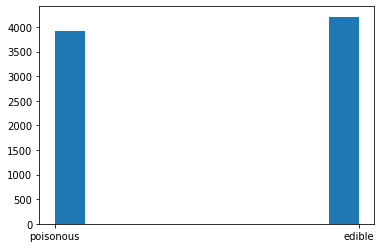

In [21]:
fig, ax = plt.subplots()
ax.hist(dataset.dv)
plt.show()

From this, we see that we are dealing with a rather balanced dataset. One class is not more represented than another by a significant margin. This is important to note when splitting data into training and test sets.

# Step 2 Part 2: Investigating Missing Values

From the txt file, we learned that missing values are labeled as "?". Therefore, we must first replace all instances of "?" with a null value


In [22]:
# replacing missing values

cleaned_dataset = dataset.replace('?', np.nan)

In [23]:
# Examining missing values

def missing_values_table(dataset):
    
    # Finds total number of null values per column
    missing_sum = dataset.isnull().sum()
    
    # Finds percentage of values that are null per column
    missing_percentage = round(100 * missing_sum/len(dataset),2).astype(str) + " %"
    
    # Creates a dataframe with the results. Axis = 1 argument makes it a column bind, while axis = 0 (default) makes it a row bind
    missing_table = pd.concat([missing_sum, missing_percentage], axis = 1)
    # Rename the table columns and sort the table by percentage of missing descending
    missing_table = missing_table.rename(columns = {0: "Total missing values", 1: "Percent missing"})
    missing_table = missing_table[missing_table["Total missing values"] > 0].sort_values(by = "Percent missing", ascending = False)
    
    # Print some summary information
    print(f"There are {missing_table.shape[0]} column(s) with missing values, out of {dataset.shape[1]} columns total.")
    print("\n")
    # Return the dataframe with missing information
    return(missing_table)

In [24]:
missing_values_table(cleaned_dataset)

There are 1 column(s) with missing values, out of 23 columns total.




,Total missing values,Percent missing
stalk-root,2480,30.53 %


In [25]:
# See if the stalk-root variable has a high correlation with the dependent variable. If not, may want to drop the variable, as almost a third
# of the data is missing.

# Assigns 0 to edible, 1 to poisonous
stalk_df = dataset
stalk_df["dv"] = np.where(stalk_df["dv"] == "edible", 0, 1)
Poisonous_Count = stalk_df.groupby(stalk_df["stalk-root"]).dv.sum()
Total_Count = stalk_df.groupby(stalk_df["stalk-root"]).dv.count()
Percentage_Poisonous = Poisonous_Count/Total_Count


In [26]:
# 71% of mushrooms with missing stalk-root variable are poisonous
Percentage_Poisonous

stalk-root
?          0.709677
bulbous    0.491525
club       0.079137
equal      0.228571
rooted     0.000000
Name: dv, dtype: float64

From this analysis, we see that the mushrooms with a missing value for the stalk-root variable have a disproportionately high rate of toxicity. Therefore, the missing value is MNAR, or not missing at random. It may be more beneficial for the model to keep the missing value.

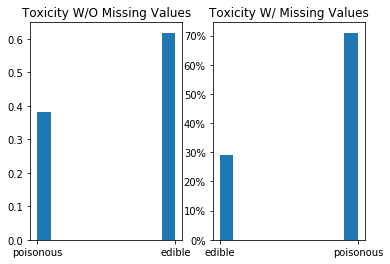

In [27]:
# Note that edible = 0 and poisonous = 1. Mushrooms with missing stalk-root values are more poisonous than not, while the mushrooms with 
# stalk-root values are more likely to be edible than not.
missings = cleaned_dataset[cleaned_dataset["stalk-root"].isnull()]
not_missing = cleaned_dataset[~cleaned_dataset["stalk-root"].isnull()]

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.hist(not_missing["dv"], weights =  [1/len(not_missing["dv"])] * len(not_missing["dv"]))
ax2.hist(missings["dv"], weights = [1/len(missings["dv"])] * len(missings["dv"]))
ax1.set_title("Toxicity W/O Missing Values")
ax2.set_title("Toxicity W/ Missing Values")


plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

The nature of the missing value is case specific and thus requires research about mushrooms themselves. Research shows that not all mushrooms have stalks. Therefore, the missing value in the stalk-root column most likely signify that the mushroom does not have a stalk. 

In [28]:
# update dataset with missing value finding
cleaned_dataset["stalk-root"] = cleaned_dataset["stalk-root"].replace(np.nan,"no stalk")

In [29]:
cleaned_dataset["stalk-root"].value_counts()

bulbous     3776
no stalk    2480
equal       1120
club         556
rooted       192
Name: stalk-root, dtype: int64

In [62]:
cleaned_dataset["dv"] = np.where(cleaned_dataset["dv"] == "poisonous", 1, 0)

# Step 2 Part 3: Analysis of Remaining Variables 

With the basic understanding of the dependent variable and the nature of our missing value, the objective of our EDA hence forth will be to understand how different variables relate to the toxicity of mushrooms. 

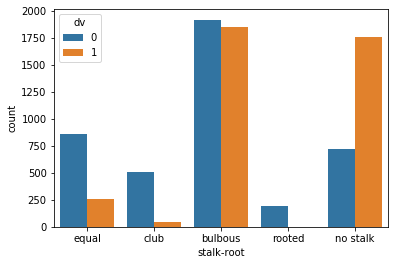

In [285]:
sns.countplot(cleaned_dataset["stalk-root"], hue = cleaned_dataset['dv'])

In [288]:
# Create a list of independent variable names
cols = list(cleaned_dataset.columns)[1:]

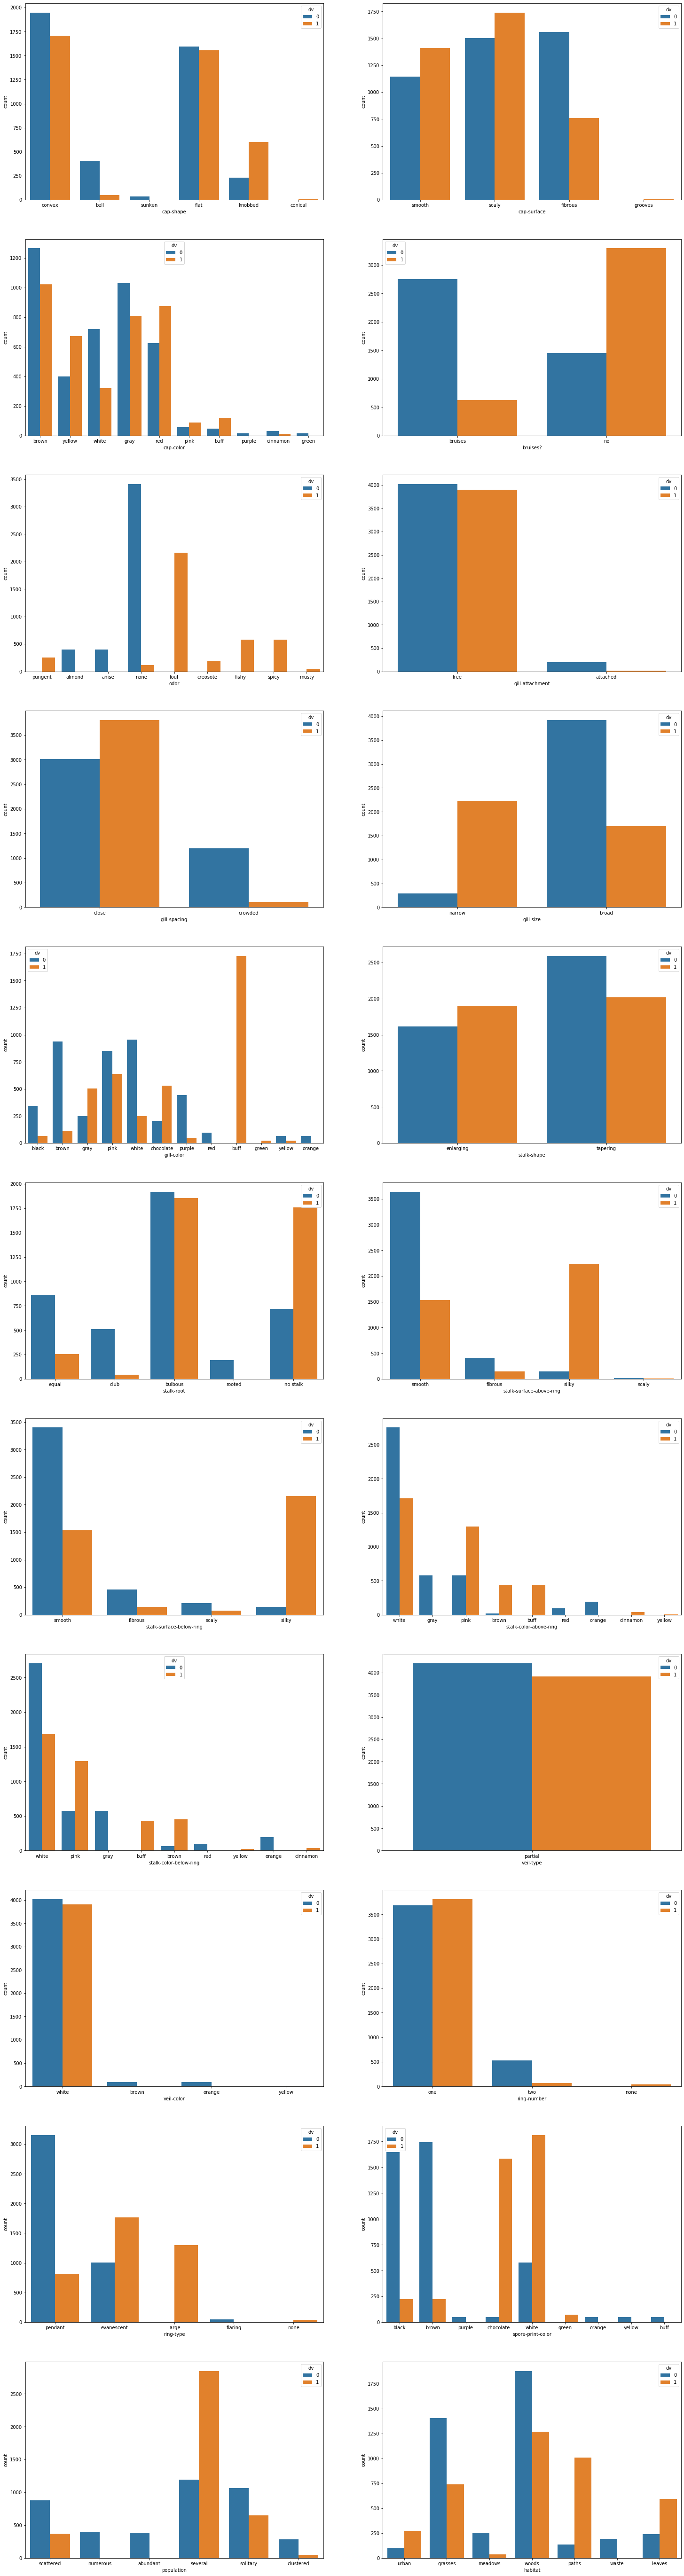

In [318]:
# Create a bar plot to see the distribution of different values per column by edibleness. 
# Assigned: 0 to edible, 1 to poisonous
fig, axes = plt.subplots(11, 2, figsize = (25, 100))
for col in cols:
    i = cols.index(col)
    countplot = sns.countplot(col, hue = 'dv', data = cleaned_dataset, ax = axes[i//2, i%2])
plt.show()

Notable findings:

1. Mushrooms with fiberous cap surfaces have an around 50% more likely chance for it to be edible, while other variations of cap surfaces tend to be more poisonous. 
2. Mushrooms with bruises tend to be edible, while mushrooms without bruises tend to be poisonous, although the association isn't exceptionally strong.
3. Silky stalk roots tend to correlate with poisonous mushrooms, while smooth stalk roots tend to correltate with edible mushrooms.
4. The veil-type column only takes one value - can drop
5. Ring number column is ordinal, while all other columns are non-ordinal. The ring-number column will be ordinal encoded, while the other columns will be one-hot encoded.

In [30]:
# Drop the veil-type column, as it only takes one value. No useful information is added for classification.

cleaned_dataset["veil-type"].value_counts()

cleaned_dataset.drop(columns = ["veil-type"], inplace = True)

In [31]:
# Ordinal encode the ring-number column

ring_number_dict = {"none": 0,
                    "one": 1,
                    "two":2}

cleaned_dataset["ring-number"].replace(ring_number_dict, inplace = True)

In [32]:
# In order to create a correlation matrix, I will first use the pd.get_dummies() function to one-hot encode the variables, as the function 
# will produce a pandas DataFrame rather than a sparse matrix.

# Create a dataframe of the categorical variables that will be one-hot encoded
cleaned_dataset_cat = cleaned_dataset.drop(columns = ["dv", "ring-number"])

# Use the get_dummies function to one-hot encode the appropriate columns
cdc_dummies = pd.get_dummies(cleaned_dataset_cat)

In [25]:
# Concatenate the variables that were not one-hot encoded to the dataframe with the dummy variables.

info_to_concat = cleaned_dataset[["dv", "ring-number"]]

full_dummies_data = pd.concat([info_to_concat,cdc_dummies], axis = 1)

In [35]:
full_dummies_data["dv"] = np.where(full_dummies_data["dv"] == "poisonous", 1, 0)

In [36]:
# Create a correlation matrix to find variables that correlate the most with the dependent vairable

correlations = full_dummies_data.corr()

# Find the variables that correlated the most with the dependent variable

correlations["dv"].sort_values(ascending = False).head(10)

dv                                1.000000
odor_foul                         0.623842
stalk-surface-above-ring_silky    0.587658
stalk-surface-below-ring_silky    0.573524
gill-size_narrow                  0.540024
gill-color_buff                   0.538808
bruises?_no                       0.501530
spore-print-color_chocolate       0.490229
ring-type_large                   0.451619
population_several                0.443722
Name: dv, dtype: float64

The resulting correlations are congruent with the insights apparent from the countplots generated earlier. I was personally surprised that the correlation for gill-color_buff and ring-type_large was not higher.

The data will be now preprocessed for modeling. 

# Step 3: Data Preprocessing

In [63]:
X = cleaned_dataset.iloc[:,1:]
y = cleaned_dataset.iloc[:,0]

In [64]:
# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split
X = cleaned_dataset.iloc[:,1:]
y = cleaned_dataset.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [65]:
# Remove ring-number column from X sets for it to be label encoded

X_tr_ring = X_train["ring-number"] 
X_te_ring = X_test["ring-number"]

X_train = X_train.drop(columns = ["ring-number"])
X_test = X_test.drop(columns = ["ring-number"])

In [66]:
# One-hot encode the other categorical columns

from feature_engine.encoding import OneHotEncoder

encoder = OneHotEncoder(
    top_categories=22,
    drop_last=False)

encoder.fit(X_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [67]:
# Merge the ring-number column back to the respective datasets
X_train["ring-number"] = X_tr_ring
X_test["ring-number"] = X_te_ring

# Section 2: Modeling

I will be comparing the accuracies of Logistic Regression, Random Forest, and XG Boost classifiers. The classifier with the highest accuracy will then be tuned to minimize false negatives.

# Step 1: Cross Validation of Different Models

In [93]:
# Finding cross-validation score of logistic regression model

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
LR = LogisticRegression()

scores = cross_val_score(LR, X_train, y_train, scoring = "neg_log_loss", cv = 10)

LR_LL_scores = -scores

LR_evaluation = LR_LL_scores.mean()

In [94]:
# Finding cross-validation score of Random Forrest model 

from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
scores = cross_val_score(RF, X_train, y_train, scoring = "neg_log_loss", cv = 10)

RF_LL_scores = -scores

RF_evaluation = RF_LL_scores.mean()

In [96]:
# Finding cross-validation score of XGB model 


from xgboost import XGBClassifier

XGB = XGBClassifier()

scores = cross_val_score(XGB, X_train, y_train, scoring = "neg_log_loss", cv = 10)

XGB_LL_scores = -scores

XGB_evaluation = XGB_LL_scores.mean()

[13:45:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:45:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:45:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:45:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [109]:
# Compare the log-loss values of the three models

print(LR_evaluation)
print(RF_evaluation)
print(XGB_evaluation)
print("\n")

evaluations = {"Logistic Regression" : LR_evaluation,
              "Random Forest" : RF_evaluation,
              "XG Boost" : XGB_evaluation}

print(f'The {min(evaluations, key = evaluations.get)} model had the lowest log-loss score of {evaluations[min(evaluations.keys(), key = (lambda k: evaluations[k]))]}.')


0.006260251513795813
0.0003996174421006159
0.0005804067898948363


The Random Forest model had the lowest log-loss score of 0.0003996174421006159.


The Random Forest model will now be tuned to minimize false negative rates, to circumvent misclassification of poisonous mushrooms as edible mushrooms. This will be done by maximizing sensetivity, as increasing sensetivity increases true positive rates, meaning that the model will maximize the ability to correctly predict that the mushroom is poisonous, even if it leads to the model sometimes misclassifying edible mushrooms as poisonous.

Equation of sensitivity is TP/(TP + FN). Sensitivity is maximized by maximizing the model's true positive rate and minimizing the false negative rate.

# Step 2: Tuning the model

RandomizedSearch will be used to tune the model 

In [112]:
from sklearn.model_selection import RandomizedSearchCV

############# Credit of subsequent code goes to the writer of:                                                                 ###############
############# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 ###############


# Number of estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in estimator
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Generate grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Initiate RandomizedSearch Cross validation

rf_random = RandomizedSearchCV(estimator = RF, param_distributions = random_grid, scoring = "recall",
                               n_iter = 10, cv = 10, verbose=1, random_state=42, n_jobs = 1)

# Fit the RandomizedSearch algorithm to the dataset

rf_random.fit(X_train, y_train)

In [119]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

In [161]:
# Compare the sensitivity (recall) of the base model and the tuned model
from sklearn.metrics import recall_score

def evaluate_model(model, test_features, test_labels):
    predictions = model.predict(test_features)
    sensitivity = recall_score(test_labels, predictions)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print("##### Model Evaluation #####")
    print("sensitivity: ", sensitivity)
    print("accuracy: ", accuracy)
    print("number of classification errors: ",errors.sum())
    return None
          
base_model = RandomForestClassifier()
base_model.fit(X_train, y_train)

# Evaluation of base model
print("Base Model: ")
evaluate_model(base_model, X_test, y_test)


# Using the cross validated model with highest recall
tuned_model = rf_random.best_estimator_

# Evaluation of the tuned model
print("\n")
print("Tuned Model: ")
evaluate_model(tuned_model, X_test, y_test)

          

Base Model: 
##### Model Evaluation #####
sensitivity:  1.0
accuracy:  100.0
number of classification errors:  0


Tuned Model: 
##### Model Evaluation #####
sensitivity:  1.0
accuracy:  100.0
number of classification errors:  0


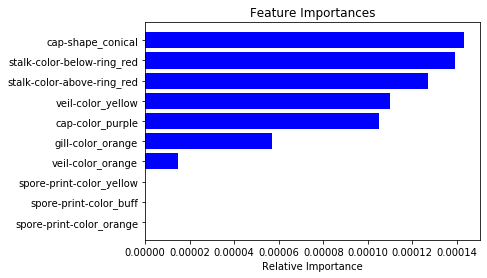

In [157]:
# Finding the top 10 most important features for classification

features = list(X_test.columns)
importances = tuned_model.feature_importances_
indices = np.argsort(importances)
indices = indices[0:10]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Conclusion

The sensitivity and accuracy for my models both before and after parameter tuning unfortunately ended up being a hundred percent. This is a very rare phenomenon in machine learning, and should be a red flag for overfitting or incorrect procedures in 99% of the cases. However, this is a very rare case in which the dataset yields extremely accurate models given proper procedures. I believe this is the case due to three reasons:

1. The author for the write-up for this dataset mentions that models have reached > 99% accuracy (see Section 1 Step 1).
2. The models were already nearing 0 log-loss during the cross-validation phase (see Section 2 Step 1). 
3. Other works on the same dataset reproduce similar results (see https://datascienceplus.com/mushrooms-classification-part-2/)

The unfortunate part is that I could not explore finding optimal classification threshold via ROC AUC curve to maximize model sensitivity, because the sensitivity at the default classification threshold of p = 0.5 already reached 1. Nevertheless, I hope the intuition for why maximizing sensitivity, or recall, was well communicated. From the perspective of the consumer using this model to determine whether his/her mushroom is edible or not, misclassifying an edible mushroom as poisonous is much prefered over misclassifying a poisonous mushroom as an edible one.

However, some interesting information about mushrooms were uncovered through this project. For example, nine out of the ten features that impacted classification the most on the tuned model were about colors. From this, I can infer that colors are an important signal for determining safety of mushroom consumption. Also, from the EDA I discovered that every mushroom with its smell described as "foul" was poisonous. These findings emphasize the importance of using scent and vision to classify what is edible and what is not. 


Future projects with mushroom classifications can include collecting and including more features, or training a neural network with images of different mushrooms and classifying their species as well as their toxicity. 